### Code to normalize mean luminance and contrast from experimental images. 
The idea is to homogenize stimuly so that we can avoid the main contrast effects that are affecting the pupil

C:\Users\arturoV\AppData\Local\Temp\ipykernel_8380\3300315.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  shape_images = imageio.imread(files[0]).shape
C:\Users\arturoV\AppData\Local\Temp\ipykernel_8380\3300315.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(filename)


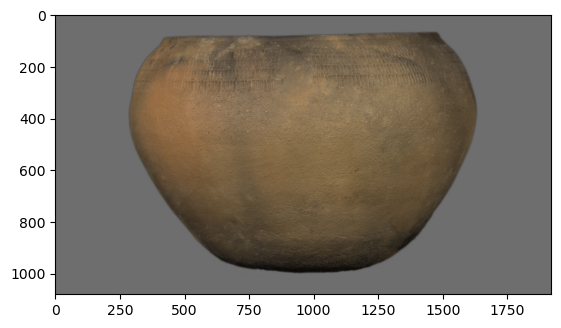

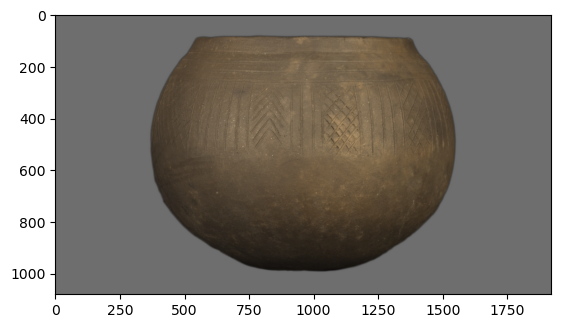

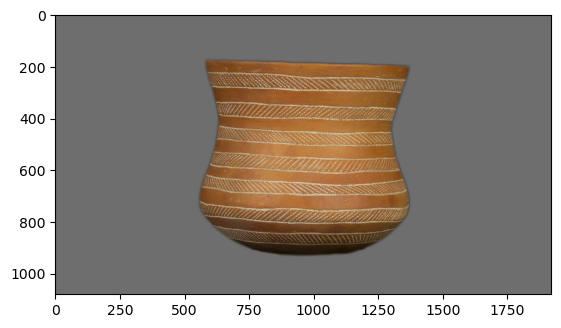

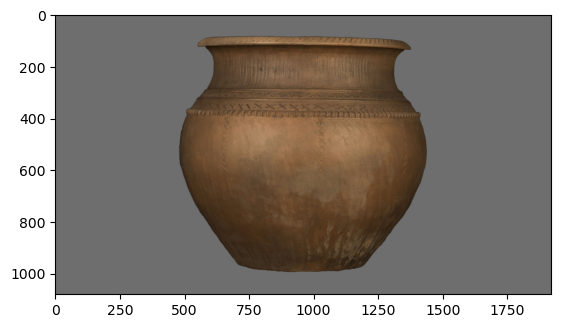

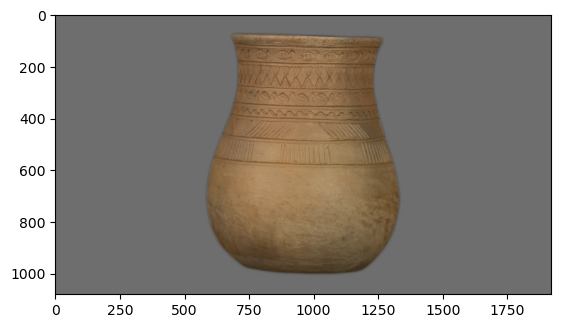

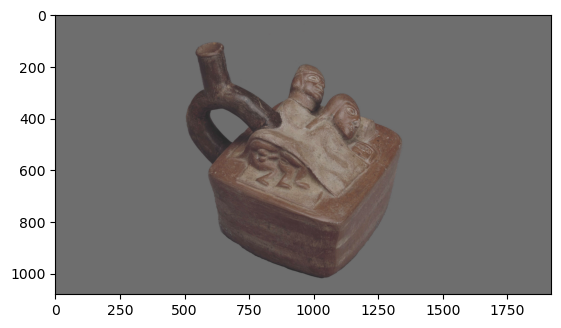

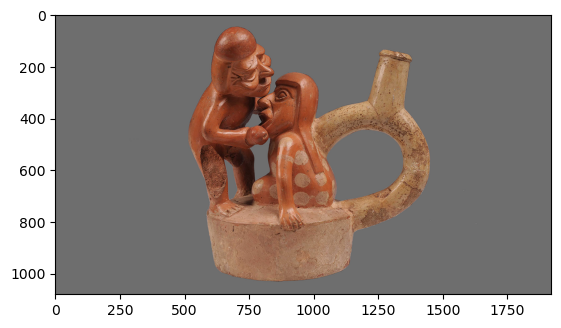

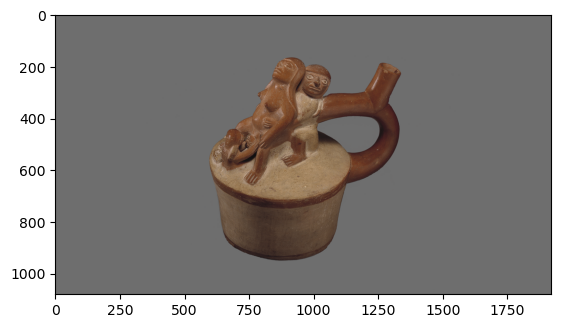

Read 8 images with shape (1080, 1920, 3) from original-images.


In [1]:
%matplotlib inline
import imageio
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import cv2
SOURCE_FOLDER = 'original-images'
DEST_FOLDER = 'matched-images'
#remove background
background_color = (110)  # Example: Red background color

files = list(Path(SOURCE_FOLDER).iterdir())
files=files[:-1]
n_images = len(files)
shape_images = imageio.imread(files[0]).shape
images = np.zeros((n_images,) + shape_images, dtype=float)
for i, filename in enumerate(files):
    im = imageio.imread(filename)
    # Compute the mask for the background color
    mask = cv2.inRange(im, background_color, background_color)
    
    # Apply the mask to remove the background color
    image_removed = cv2.bitwise_and(im, im, mask=~mask)
    plt.imshow(image_removed)
    plt.show()
    images[i] = im
    

print(f'Read {n_images} images with shape {shape_images} from {SOURCE_FOLDER}.')

Lets see the mean pixel value(intensity) and std (contrast) of the original images, including the background

In [2]:
for i in range(n_images):
    print(f'{i}: intensity={images[i].mean()}, contrast={images[i].std()}')

0: intensity=99.68967528292181, contrast=23.438221943833213
1: intensity=95.98063577031893, contrast=24.655053299928966
2: intensity=109.12451919367284, contrast=25.79294318412048
3: intensity=98.85143823945474, contrast=25.098049681961957
4: intensity=108.50963847093621, contrast=18.093049434395365
5: intensity=105.85938143004115, contrast=15.943203784986679
6: intensity=109.30213300540123, contrast=24.63457335588795
7: intensity=105.3930507330247, contrast=18.549427776366326


Lets see the mean pixel value(intensity) and std (contrast) of the original images, excluding the background

In [3]:
for i in range(n_images):
    print(f'{i}: intensity={images[i][images[i] !=background_color].mean()}, contrast={images[i][images[i] !=background_color].std()}')

0: intensity=89.32512421661495, contrast=29.78764768726998
1: intensity=78.19465296691081, contrast=28.5196842280461
2: intensity=106.67592910199522, contrast=50.17783173143333
3: intensity=78.00716820911482, contrast=33.77544158090279
4: intensity=104.77094149370876, contrast=33.60081380154229
5: intensity=91.1719076648685, contrast=29.652798052562908
6: intensity=107.36131834067771, contrast=47.848357181285664
7: intensity=83.67012538862389, contrast=37.343662998686725


To equalize the mean pixel value (intensity) and standard deviation (contrast),
we perform the following steps for each image

- subtract the mean value, thus setting the mean to 0
- divide by the standard deviation of the stimulus, thus setting the standard
  deviation to 1
- multiply by the grand mean (=across all images) standard deviation
- add the grand mean value

In [4]:
STD_REDUCTION = 0.75

grand_mean_intensity = images[images!=background_color].mean()
grand_mean_std = images[images!=background_color].std() * STD_REDUCTION
for i in range(n_images):
    images[i][images[i] !=background_color] -= images[i][images[i] !=background_color].mean()
    images[i][images[i] !=background_color] /= images[i][images[i] !=background_color].std() / grand_mean_std
    images[i][images[i] !=background_color] += grand_mean_intensity
images = np.clip(images, 0, 255)

Let's check the mean pixel value (intensity) and standard deviation (contrast)
of the matched images. They should be almost identical for all images! If there
are still differences, this is because some of the pixel values were adjusted
to be out of the 0 - 255 range. To avoid this from happening, decrease the
STD_REDUCTION value above. This reduces the contrast for all images, thus
avoiding pixel values from exceeding the 0 - 255 range.

In [5]:
for i in range(n_images):
    print(f'{i}: intensity={images[i][images[i] !=background_color].mean()}, contrast={images[i][images[i] !=background_color].std()}')

0: intensity=91.0515981351928, contrast=28.317622977299887
1: intensity=91.05159170838166, contrast=28.31758504790346
2: intensity=91.05159813519282, contrast=28.31762297729987
3: intensity=91.05159813519283, contrast=28.317622977299894
4: intensity=91.05159813519272, contrast=28.31762297729988
5: intensity=91.05159813519285, contrast=28.31762297729988
6: intensity=91.0515981351928, contrast=28.317622977299877
7: intensity=91.05159813519278, contrast=28.31762297729988


Write the matched images to file and show them.

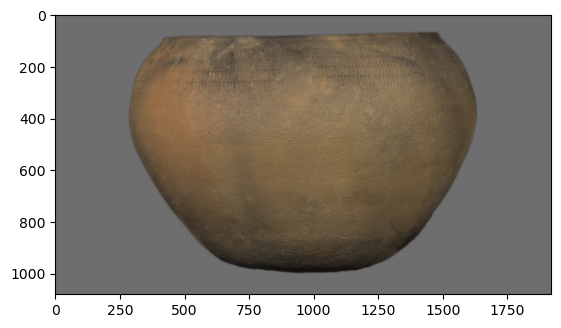

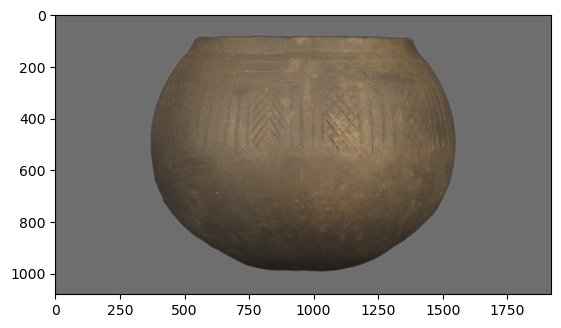

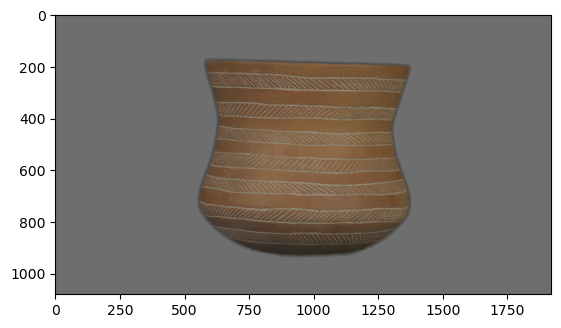

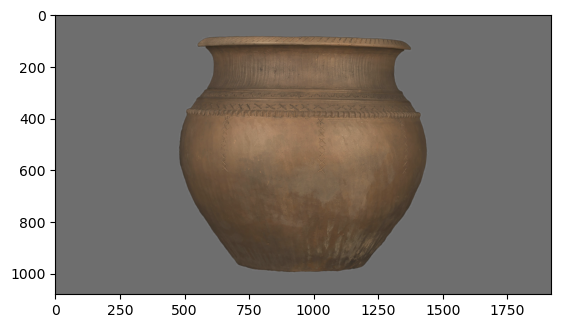

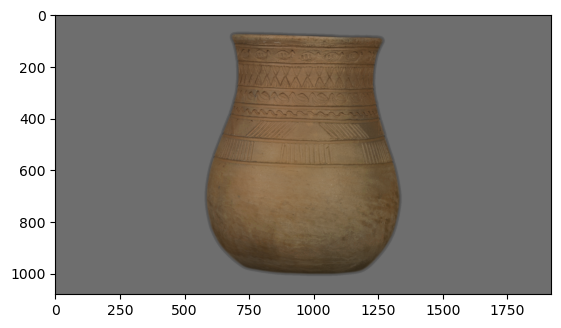

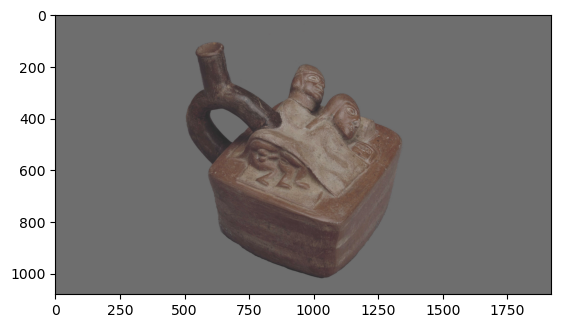

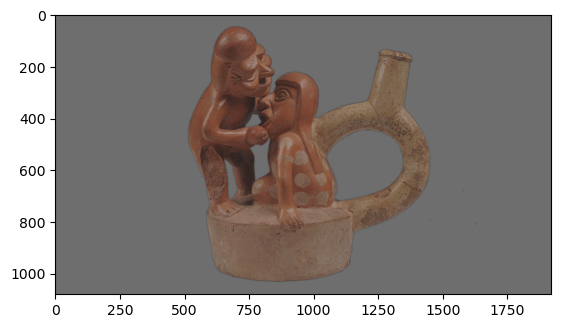

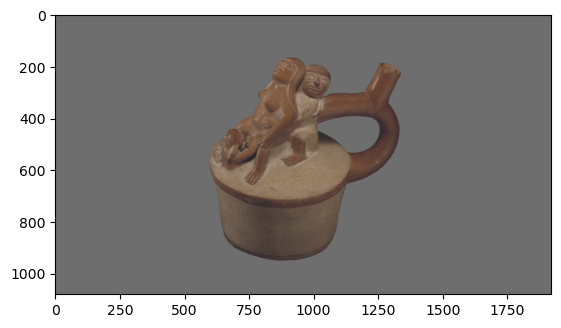

In [6]:
%matplotlib inline
for i, filename in enumerate(files):
    im = np.array(images[i], dtype=np.uint8)
    plt.imshow(im)
    plt.show()
    imageio.imwrite(Path(DEST_FOLDER) / filename.name, im)
    

Now lets see the histograms of the original vs the transformed images

### ORIGINAL

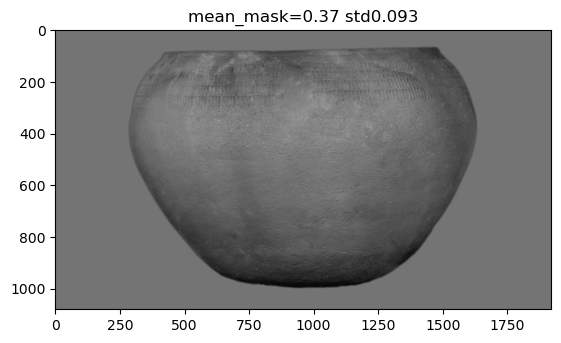

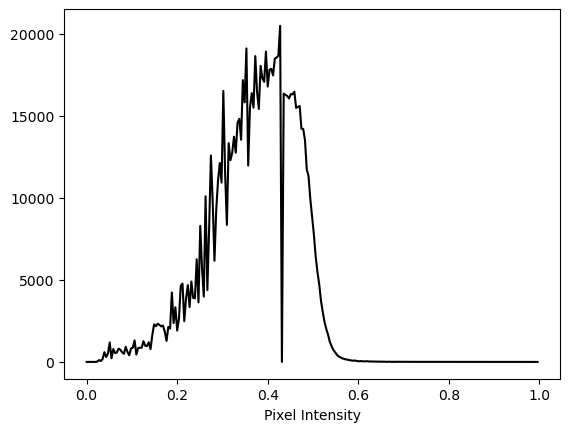

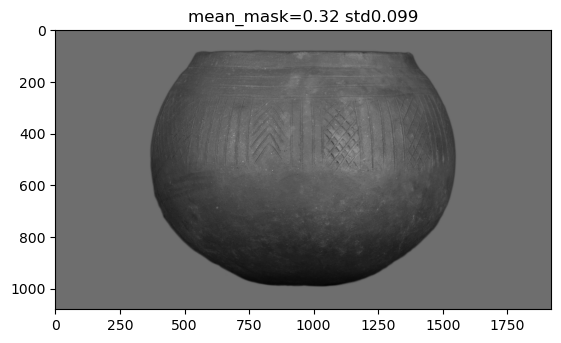

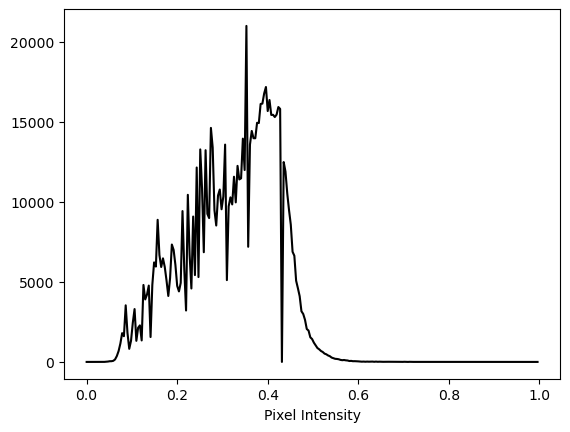

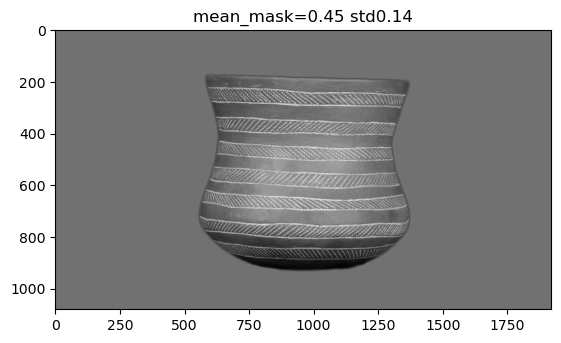

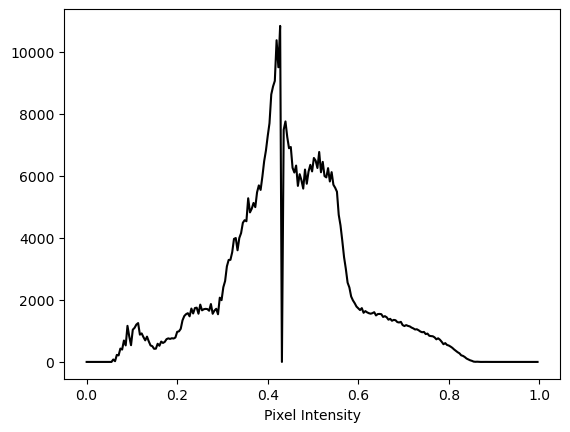

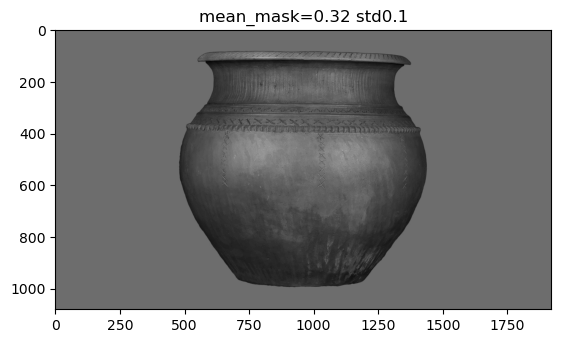

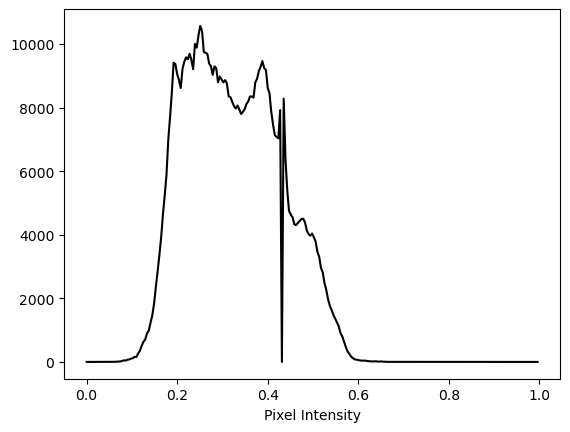

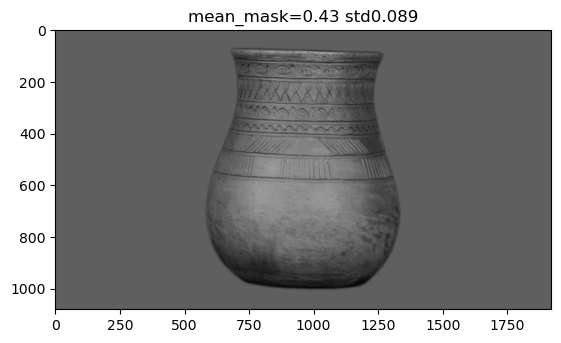

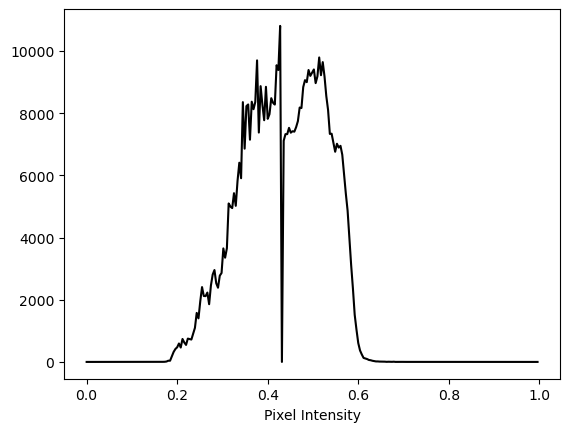

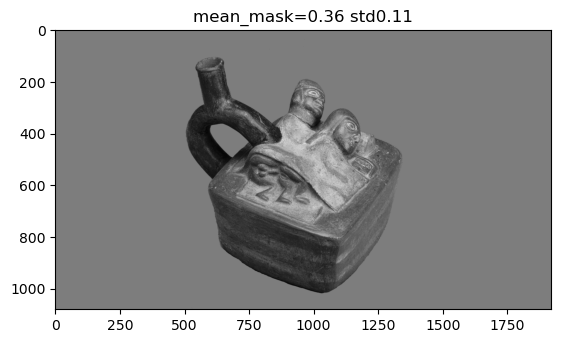

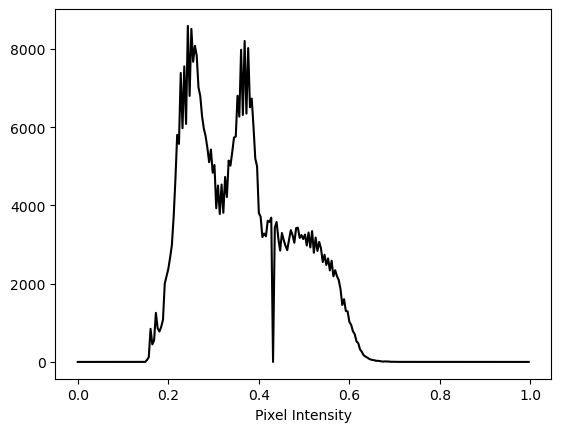

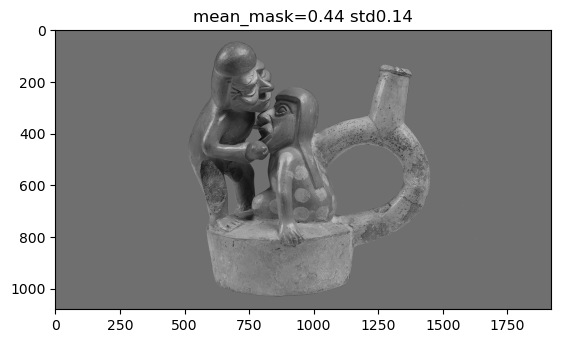

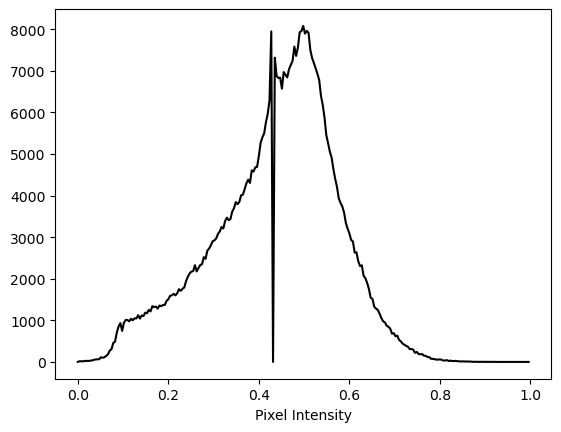

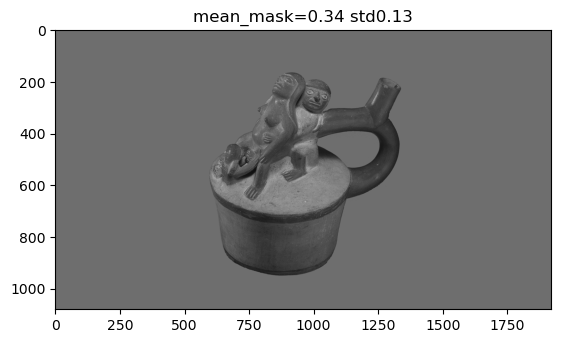

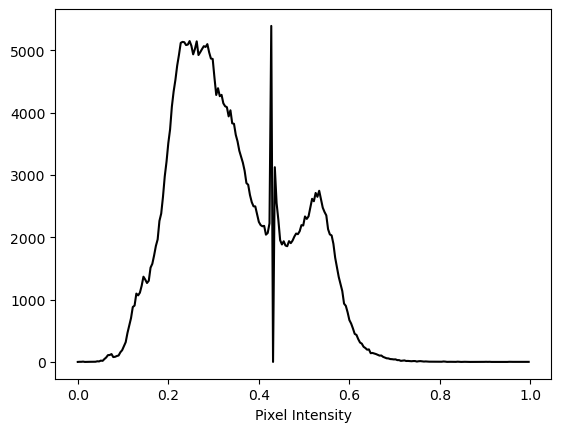

TypeError: Image data of dtype object cannot be converted to float

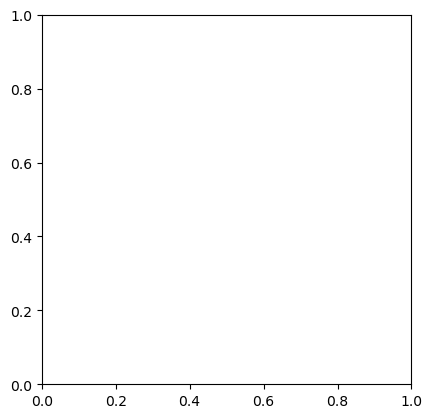

In [7]:
import os
%matplotlib inline
EXP_IMAGES_PATH=Path(r'original-images')

images=[]
images_list=os.listdir(EXP_IMAGES_PATH)
# images_list.remove('assets.txt')
n_images = len(images_list)
images_strip=list(map(lambda x: x.split('.')[0].split('_')[0],images_list)) #remove .tiiff and '_'
data_dict=dict([('assets',[]),('mean_lum_mask',[]),('std_lum_mask',[]),('mean_lum',[]),('std_lum',[])])

for  filename,images_stripped in zip(images_list,images_strip):
    im = cv2.imread(str(EXP_IMAGES_PATH.joinpath(filename)),cv2.IMREAD_GRAYSCALE)
    fig1,ax1=plt.subplots(1,)
    ax1.imshow(im,cmap='gray')
    #remove background
    background_color = (110)  # Example: Red background color


    # Compute the mask for the background color
    mask = cv2.inRange(im, background_color, background_color)


    # Apply the mask to remove the background color
    image_removed = cv2.bitwise_and(im, im, mask=~mask)

    # Convert pixel values to the range of 0 to 1
    image_normalized = image_removed.astype(np.float32) / 255.0

    # Apply the mask to the normalized image
    image_normalized_masked = cv2.bitwise_and(image_normalized, image_normalized, mask=~mask)

 # Calculate the histogram with bins between 0 and 1
    hist, bins = np.histogram(image_normalized[image_normalized>0], bins=np.linspace(0, 1, num=256))
    
    # Plot the histogram
    
    fig2,ax2=plt.subplots(1,)
    plt.plot(bins[:-1], hist, color='black')
    plt.xlabel('Pixel Intensity')
    ax1.set_title(f'mean_mask={np.mean(image_normalized[image_normalized>0]):.2} std{np.std(image_normalized[image_normalized>0]):.2}')
    plt.show()

    #ADD DATA to dataframe
    data_dict['assets'].append(images_stripped)
    data_dict['mean_lum_mask'].append(np.mean(image_normalized[image_normalized>0]))
    data_dict['std_lum_mask'].append(np.std(image_normalized[image_normalized>0]))
    data_dict['mean_lum'].append(np.std(image_normalized))
    data_dict['std_lum'].append(np.std(image_normalized))

## transformed images

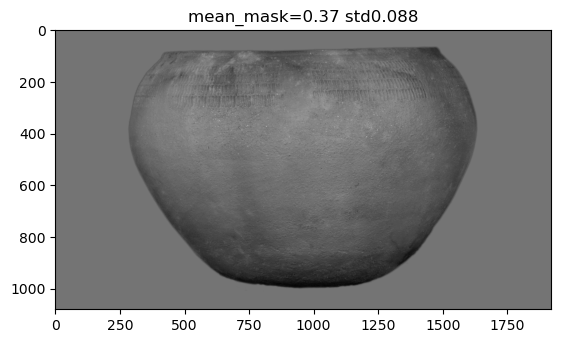

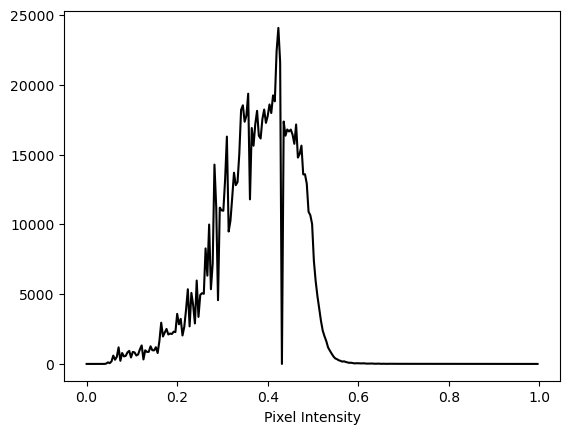

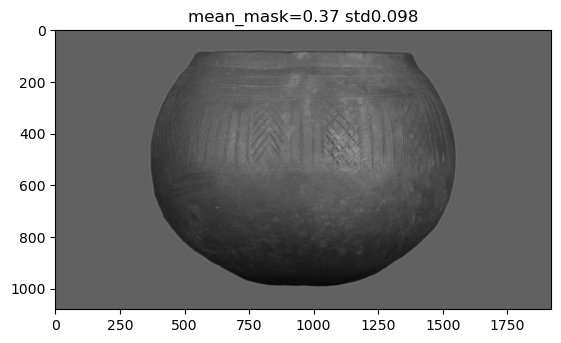

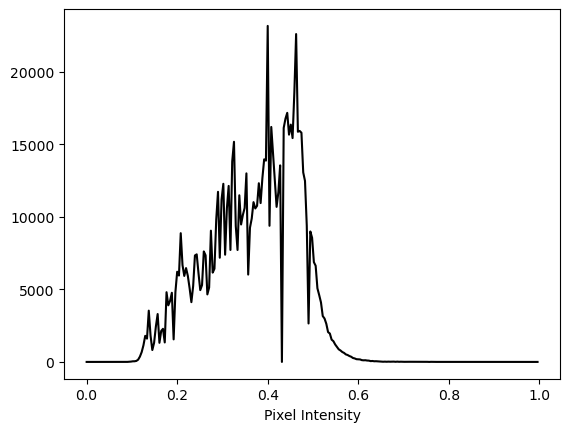

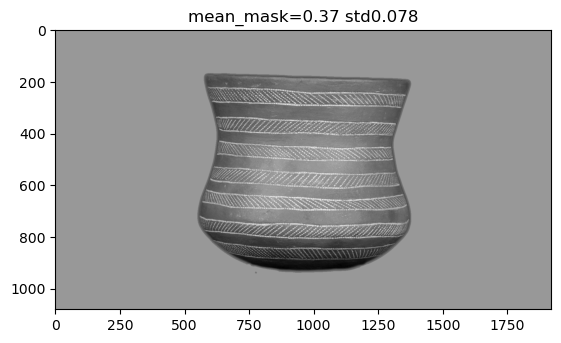

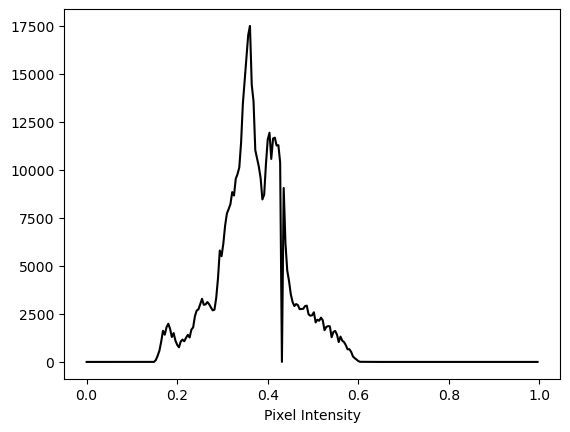

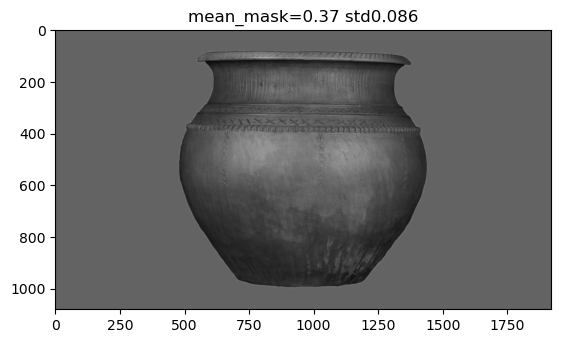

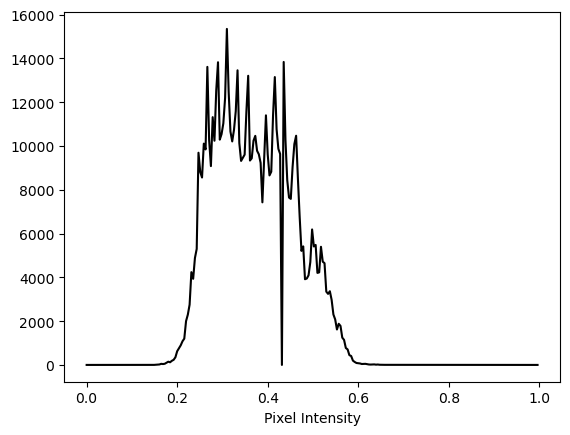

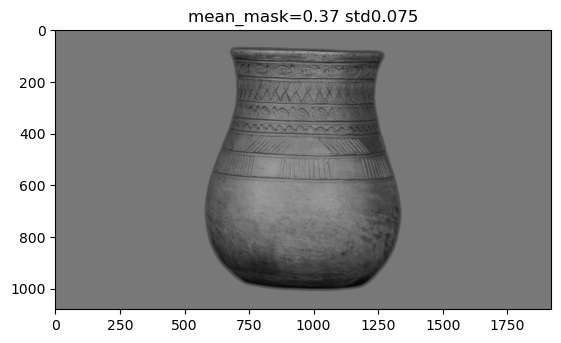

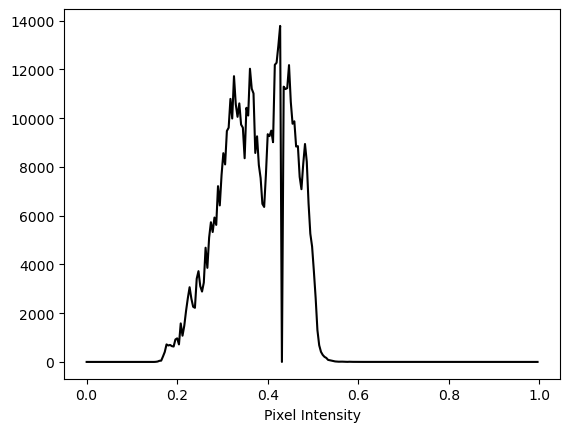

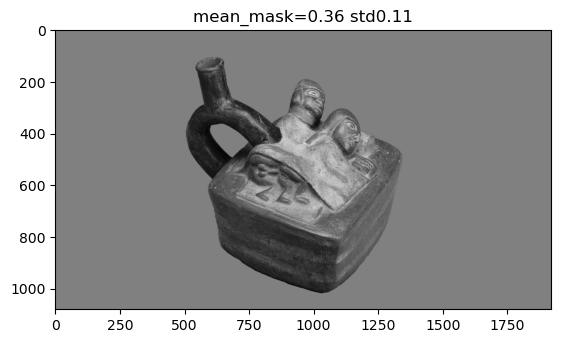

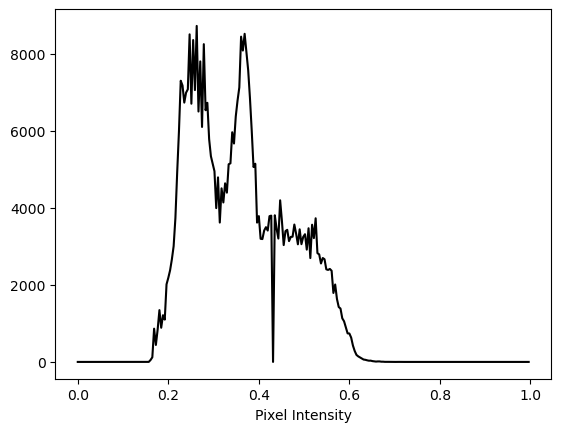

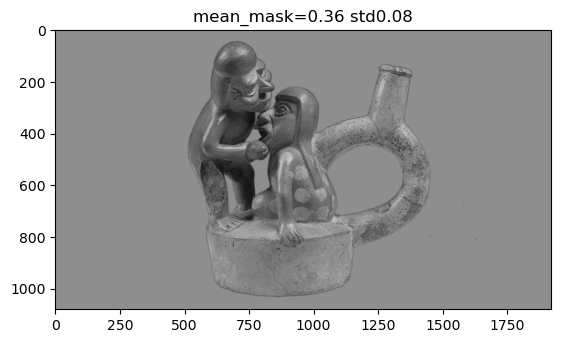

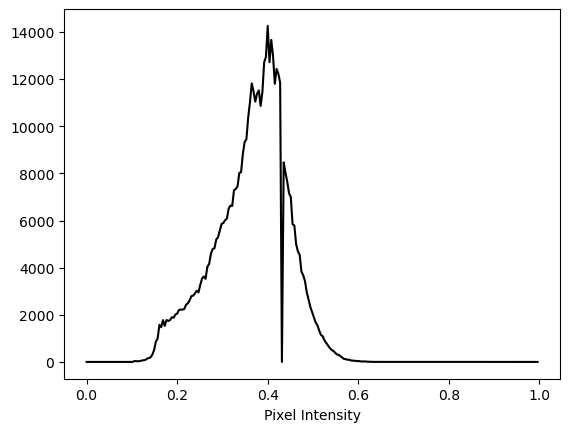

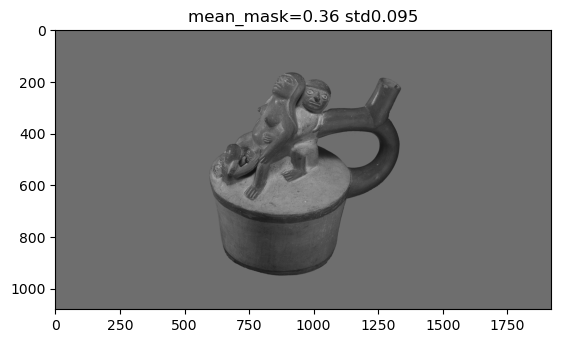

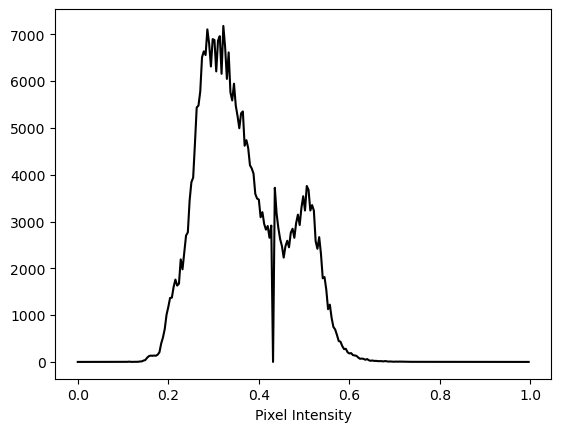

TypeError: Image data of dtype object cannot be converted to float

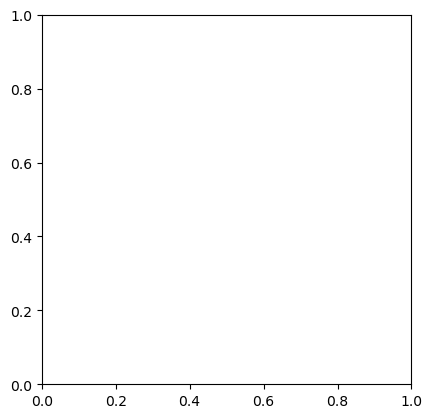

In [8]:
import os
%matplotlib inline
EXP_IMAGES_PATH=Path(r'matched-images')

images=[]
images_list=os.listdir(EXP_IMAGES_PATH)
# images_list.remove('assets.txt')
n_images = len(images_list)
images_strip=list(map(lambda x: x.split('.')[0].split('_')[0],images_list)) #remove .tiiff and '_'
data_dict=dict([('assets',[]),('mean_lum_mask',[]),('std_lum_mask',[]),('mean_lum',[]),('std_lum',[])])

for  filename,images_stripped in zip(images_list,images_strip):
    im = cv2.imread(str(EXP_IMAGES_PATH.joinpath(filename)),cv2.IMREAD_GRAYSCALE)
    fig1,ax1=plt.subplots(1,)
    ax1.imshow(im,cmap='gray')
    #remove background
    background_color = (110)  # Example: Red background color


    # Compute the mask for the background color
    mask = cv2.inRange(im, background_color, background_color)


    # Apply the mask to remove the background color
    image_removed = cv2.bitwise_and(im, im, mask=~mask)

    # Convert pixel values to the range of 0 to 1
    image_normalized = image_removed.astype(np.float32) / 255.0

    # Apply the mask to the normalized image
    image_normalized_masked = cv2.bitwise_and(image_normalized, image_normalized, mask=~mask)

 # Calculate the histogram with bins between 0 and 1
    hist, bins = np.histogram(image_normalized[image_normalized>0], bins=np.linspace(0, 1, num=256))
    
    # Plot the histogram
    
    fig2,ax2=plt.subplots(1,)
    plt.plot(bins[:-1], hist, color='black')
    plt.xlabel('Pixel Intensity')
    ax1.set_title(f'mean_mask={np.mean(image_normalized[image_normalized>0]):.2} std{np.std(image_normalized[image_normalized>0]):.2}')
    plt.show()

    #ADD DATA to dataframe
    data_dict['assets'].append(images_stripped)
    data_dict['mean_lum_mask'].append(np.mean(image_normalized[image_normalized>0]))
    data_dict['std_lum_mask'].append(np.std(image_normalized[image_normalized>0]))
    data_dict['mean_lum'].append(np.std(image_normalized))
    data_dict['std_lum'].append(np.std(image_normalized))

In [11]:
im = cv2.imread('Obj0110_Asset0048 (1).tiff',cv2.IMREAD_GRAYSCALE)
im

array([[110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110],
       ...,
       [110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110]], dtype=uint8)